<a href="https://colab.research.google.com/github/RyanXJu/Airbnb_Montreal/blob/master/PricePrediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Airbnb price in Montreal

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import scipy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# load listing datasets
root_path = 'gdrive/My Drive/Airbnb/'
listings_detail = pd.read_csv(root_path+"listings_detail.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
listings_detail.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2078,https://www.airbnb.com/rooms/2078,20200113202958,2020-01-14,Central comfy close to Metro Laurie,Centrally located in trendy Le Plateau. Join...,Centrally located clean comfy furnished room ...,Centrally located in trendy Le Plateau. Join...,none,Although my place is centrally located in Le P...,I always inform my guests the places/attractio...,I am 6-8 mins. walk to Metro Laurie and bus ro...,You will have full access in the apartment. I...,I am always available to help and give informa...,No house rules but I expect my guests to follo...,NaN,NaN,https://a0.muscache.com/im/pictures/88170231/0...,NaN,2277,https://www.airbnb.com/users/show/2277,Nelia,2008-08-19,"Montreal, Québec, Canada","Honest, quiet and adhere to the golden rules a...",within a few hours,100%,NaN,f,https://a0.muscache.com/im/users/2277/profile_...,https://a0.muscache.com/im/users/2277/profile_...,Le Plateau,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Montreal, QC, Canada",Le Plateau-Mont-Royal,Le Plateau-Mont-Royal,...,$6.00,2,7,2,2,7,7,2.0,7.0,7 weeks ago,t,0,0,0,226,2020-01-14,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,f,NaN,"{Quebec,"" CA""}",t,f,flexible,f,f,1,0,1,0,2.41
1,2843,https://www.airbnb.com/rooms/2843,20200113202958,2020-01-14,Fabulous downtown/airport room,Come stay in this trendy area of downtown Mont...,"Private individual room in the downtown area, ...",Come stay in this trendy area of downtown Mont...,none,This area of St Henri is actually downtown Mon...,From this room you can walk to downtown Montre...,There is a major metro/subway stop called Lion...,"The guests can use the kitchen anytime, fully ...",I meet guests when they arrive show them the h...,No smoking and no pets Airport bus stops acros...,NaN,NaN,https://a0.muscache.com/im/pictures/803776/a2a...,NaN,2319,https://www.airbnb.com/users/show/2319,Gail,2008-08-19,"Montreal, Québec, Canada",Manage a network of downtown rooms and private...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/7c04e...,https://a0.muscache.com/im/pictures/user/7c04e...,Little Burgundy,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Montréal, Québec, Canada",Le Sud-Ouest,Le Sud-Ouest,...,$10.00,1,365,1,1,365,365,1.0,365.0,3 days ago,t,18,18,18,18,2020-01-14,143,30,2009-06-20,2019-12-30,88.0,9.0,9.0,9.0,9.0,10.0,10.0,f,NaN,"{Quebec,"" CA""}",t,f,moderate,f,f,5,2,3,0,1.11
2,14584,https://www.airbnb.com/rooms/14584,20200113202958,2020-01-14,"Spread Out in 1,200 Square Feet of Luxury in t...",This stylish and spaciou

In [5]:
listings_detail.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20466 entries, 0 to 20465
Data columns (total 106 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20466 non-null  int64  
 1   listing_url                                   20466 non-null  object 
 2   scrape_id                                     20466 non-null  int64  
 3   last_scraped                                  20466 non-null  object 
 4   name                                          20448 non-null  object 
 5   summary                                       19503 non-null  object 
 6   space                                         13659 non-null  object 
 7   description                                   19916 non-null  object 
 8   experiences_offered                           20466 non-null  object 
 9   neighborhood_overview                         12631 non-null

# split data into train and test data

In [0]:
from sklearn.model_selection import train_test_split
data = listings_detail
train, test = train_test_split(data, test_size = 0.2, random_state = 42)

In [7]:
print("training data size : ", train.shape)
print("testing data size : ", test.shape)

training data size :  (16372, 106)
testing data size :  (4094, 106)


### select features

In [8]:
## amenities, need to separate to tokens
df_train = train.loc[:, ["host_response_time",
                               "host_response_rate",
                               "host_is_superhost",
                               "host_identity_verified",
                               "latitude",
                               "longitude",
                               "is_location_exact",
                             "neighbourhood",
                               "property_type",
                               "room_type",
                               "accommodates",
                               "bathrooms",
                               "bedrooms",
                               "beds",
                               "bed_type",
                             "number_of_reviews",
                             "review_scores_rating",
                               "price"]]
df_train.head(3)

,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,latitude,longitude,is_location_exact,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,number_of_reviews,review_scores_rating,price
11640,NaN,NaN,f,t,45.47229,-73.60412,t,Notre-Dame-de-Grace,Townhouse,Private room,2,1.0,2.0,2.0,Real Bed,77,95.0,$64.00
121,within an hour,100%,f,t,45.52371,-73.68067,t,Saint-Laurent,House,Private room,2,1.0,1.0,1.0,Real Bed,35,92.0,$44.00
2609,NaN,NaN,f,f,45.52267,-73.57168,t,Le Plateau,Apartment,Entire home/apt,4,1.0,2.0,3.0,Real Bed,3,90.0,$74.00


In [9]:
df_train.price = pd.to_numeric(df_train.price.str.replace(r"$","").str.replace(r",",""))
df_train.price.describe()

count    16372.000000
mean       113.695944
std        234.201370
min         10.000000
25%         50.000000
50%         80.000000
75%        120.000000
max      13294.000000
Name: price, dtype: float64

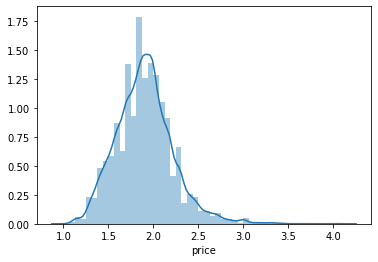

In [10]:
sns.distplot(np.log10(df_train.price))

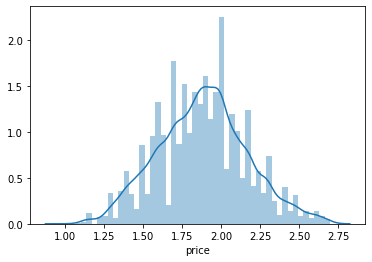

In [11]:
## cut outliers to obtain a more normal distribution

10**2.7
## 500 seems to be a reasonable point to cut outliers
sns.distplot(np.log10(df_train.price[df_train.price < 500]))

In [12]:
# check samples with price > 500
df_train.loc[df_train.price>500, :].shape

(258, 18)

In [13]:
df_train.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16372 entries, 11640 to 15795
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_response_time      9680 non-null   object 
 1   host_response_rate      9680 non-null   object 
 2   host_is_superhost       16340 non-null  object 
 3   host_identity_verified  16340 non-null  object 
 4   latitude                16372 non-null  float64
 5   longitude               16372 non-null  float64
 6   is_location_exact       16372 non-null  object 
 7   neighbourhood           16251 non-null  object 
 8   property_type           16372 non-null  object 
 9   room_type               16372 non-null  object 
 10  accommodates            16372 non-null  int64  
 11  bathrooms               16352 non-null  float64
 12  bedrooms                16348 non-null  float64
 13  beds                    16303 non-null  float64
 14  bed_type                16372 non-

In [14]:
for col in df_train:
    if(df_train[col].isnull().any()):
        print(col)


host_response_time
host_response_rate
host_is_superhost
host_identity_verified
neighbourhood
bathrooms
bedrooms
beds
review_scores_rating


# Select features for linear model


In [0]:
# keep only binary features and numeric features

# host_is_superhost         20383 non-null object
# host_identity_verified    20383 non-null object
# latitude                  20420 non-null float64
# longitude                 20420 non-null float64
# accommodates              20420 non-null int64
# bathrooms                 20392 non-null float64
# bedrooms                  20389 non-null float64
# beds                      20328 non-null float64
# number_of_reviews         20466 non-null int64
# review_scores_rating      16139 non-null float64
# price                     20420 non-null float64

# neighbourhood             20316 non-null object
# property_type             20466 non-null object
# room_type                 20466 non-null object
# bed_type                  20466 non-null object

df_train = df_train.loc[:,["host_is_superhost",
                 "host_identity_verified",
                 "latitude",
                 "longitude",
                 "accommodates",
                 "bathrooms",
                 "bedrooms",
                 "beds",
                 "number_of_reviews",
                 "review_scores_rating",
                 #"neighbourhood",
                 #"property_type",
                 "room_type",
                 "bed_type",
                 "price"]]

In [16]:
#summary of categoricals
df_train.describe(include=['O'])

,host_is_superhost,host_identity_verified,room_type,bed_type
count,16340,16340,16372,16372
unique,2,2,4,5
top,f,f,Entire home/apt,Real Bed
freq,13185,10955,11646,16199


In [0]:
# data[['property_type', 'price']].groupby(['property_type'], as_index=False).mean().sort_values(by='price',ascending=False)

In [18]:
df_train[['room_type', 'price']].groupby(['room_type'], as_index=False).mean().sort_values(by='price',ascending=False)

,room_type,price
1,Hotel room,149.900000
0,Entire home/apt,134.767388
2,Private room,61.057149
3,Shared room,53.631944


In [19]:
df_train[['bed_type', 'price']].groupby(['bed_type'], as_index=False).mean().sort_values(by='price',ascending=False)

,bed_type,price
1,Couch,114.529412
4,Real Bed,114.154207
0,Airbed,102.000000
3,Pull-out Sofa,67.090909
2,Futon,63.531250


In [0]:
# data[['neighbourhood', 'price']].groupby(['neighbourhood'], as_index=False).mean().sort_values(by='price',ascending=False)

### deal with missing value and non-numeric values

In [21]:
df_train.fillna(0, inplace=True) 
df_train = df_train.replace("f", 0).replace("t", 1)
df_train.head()

,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,room_type,bed_type,price
11640,0,1,45.47229,-73.60412,2,1.0,2.0,2.0,77,95.0,Private room,Real Bed,64.0
121,0,1,45.52371,-73.68067,2,1.0,1.0,1.0,35,92.0,Private room,Real Bed,44.0
2609,0,0,45.52267,-73.57168,4,1.0,2.0,3.0,3,90.0,Entire home/apt,Real Bed,74.0
19615,0,0,45.53227,-73.64180,2,1.0,1.0,1.0,1,0.0,Private room,Real Bed,26.0
12579,0,0,45.61096,-73.51795,2,1.0,1.0,1.0,19,97.0,Entire home/apt,Real Bed,90.0


In [22]:
#use one-hot-encoding 
categorical=['room_type','bed_type']
data_model=pd.get_dummies(df_train, columns=categorical)
data_model.head(5)
# data_model.info()

,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,price,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
11640,0,1,45.47229,-73.60412,2,1.0,2.0,2.0,77,95.0,64.0,0,0,1,0,0,0,0,0,1
121,0,1,45.52371,-73.68067,2,1.0,1.0,1.0,35,92.0,44.0,0,0,1,0,0,0,0,0,1
2609,0,0,45.52267,-73.57168,4,1.0,2.0,3.0,3,90.0,74.0,1,0,0,0,0,0,0,0,1
19615,0,0,45.53227,-73.64180,2,1.0,1.0,1.0,1,0.0,26.0,0,0,1,0,0,0,0,0,1
12579,0,0,45.61096,-73.51795,2,1.0,1.0,1.0,19,97.0,90.0,1,0,0,0,0,0,0,0,1


In [23]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16372 entries, 11640 to 15795
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_is_superhost          16372 non-null  int64  
 1   host_identity_verified     16372 non-null  int64  
 2   latitude                   16372 non-null  float64
 3   longitude                  16372 non-null  float64
 4   accommodates               16372 non-null  int64  
 5   bathrooms                  16372 non-null  float64
 6   bedrooms                   16372 non-null  float64
 7   beds                       16372 non-null  float64
 8   number_of_reviews          16372 non-null  int64  
 9   review_scores_rating       16372 non-null  float64
 10  price                      16372 non-null  float64
 11  room_type_Entire home/apt  16372 non-null  uint8  
 12  room_type_Hotel room       16372 non-null  uint8  
 13  room_type_Private room     16372 non-null 

In [24]:
data_model = data_model.loc[df_train.price <= 500, :]
data_model.describe()

,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,price,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
count,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000,16114.000000
mean,0.191883,0.329651,45.515991,-73.589276,3.438190,1.132245,1.378615,1.764304,23.238737,73.715403,96.375388,0.708390,0.003103,0.279757,0.008750,0.000310,0.000993,0.005958,0.003413,0.989326
std,0.393794,0.470101,0.031533,0.042390,2.211676,0.462232,0.972695,1.278333,45.660329,39.018477,73.956937,0.454518,0.055619,0.448894,0.093135,0.017613,0.031496,0.076957,0.058324,0.102765
min,0.000000,0.000000,45.404540,-73.964380,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,45.497312,-73.603440,2.000000,1.000000,1.000000,1.000000,1.000000,80.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,45.519310,-73.579750,3.000000,1.000000,1.000000,1.000000,6.000000,94.000000,78.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,45.534120,-73.565980,4.000000,1.000000,2.000000,2.000000,23.000000,99.000000,119.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,45.698360,-73.481890,18.000000,20.000000,20.000000,20.000000,676.000000,100.000000,500.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# normalize data

In [0]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()

features = data_model.columns[data_model.columns != "price"]

X = data_model.loc[:,features]
Y = data_model["price"]

# X_scaled = min_max_scaler.fit_transform(X)
# X_scaled = pd.DataFrame(X_scaled)
# X_scaled.columns = features
# X_scaled.describe()

## Linear regression

In [0]:
## split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [0]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [28]:
# R^2
reg.score(X_train, y_train)

0.36631855589998774

In [29]:
# predict on testing data  ## normally this is not the right way to verify
from sklearn.metrics import mean_squared_error
y_pred = reg.predict(X_val)
print("MSE_price : ", mean_squared_error(y_val, y_pred), sep="")

MSE_price : 3652.8730162380916


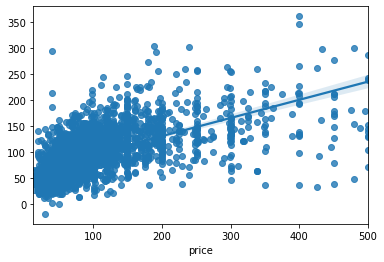

In [30]:
sns.regplot(x=y_val,y=y_pred,fit_reg=True)

count    3223.000000
mean       38.048871
std        46.966380
min         0.015528
25%        11.860443
50%        25.103414
75%        45.839200
max       431.855659
Name: price, dtype: float64


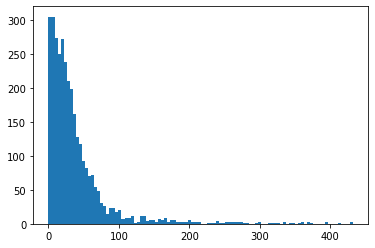

In [31]:
err= np.abs(y_pred - y_val)
print(err.describe())

plt.hist(err, bins = 100)
plt.show()

reg_logprice model R^2 : 0.4657438993515855
MSE_logged : 0.24268444264733197
MSE_price : 3911.561284176854


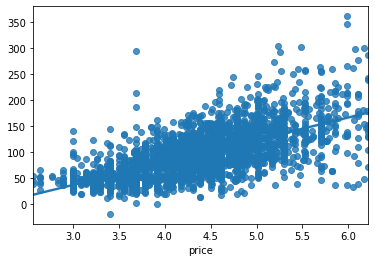

In [32]:
##
# use log price to make model
reg_log = LinearRegression().fit(X_train, np.log(y_train))

# R^2
print("reg_logprice model R^2 : " , reg_log.score(X_train, np.log(y_train)), sep= "")

sns.regplot(x=np.log(y_val),y=y_pred,fit_reg=True)

# predict on testing data
y_pred_log = reg_log.predict(X_val)

# RMSE ( Root Mean Squared Error)
print("MSE_logged : ", mean_squared_error(np.log(y_val), y_pred_log), sep="")
print("MSE_price : ", mean_squared_error(y_val, np.exp(y_pred_log)), sep="")

count    3223.000000
mean       36.560534
std        50.751235
min         0.002235
25%         9.999966
50%        20.874289
75%        40.781583
max       429.879123
Name: price, dtype: float64


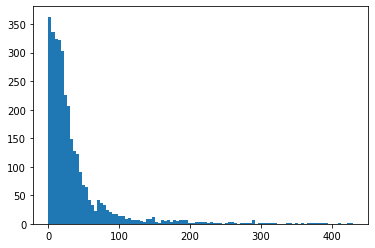

In [33]:
err_logmodel= np.abs(np.exp(y_pred_log) - y_val)
print(err_logmodel.describe())

plt.hist(err_logmodel, bins = 100)
plt.show()

# predict on testing data

In [0]:
# process testing data

df_test = test.loc[:,["host_is_superhost",
                 "host_identity_verified",
                 "latitude",
                 "longitude",
                 "accommodates",
                 "bathrooms",
                 "bedrooms",
                 "beds",
                 "number_of_reviews",
                 "review_scores_rating",
                 #"neighbourhood",
                 #"property_type",
                 "room_type",
                 "bed_type",
                 "price"]]

df_test.price = pd.to_numeric(df_test.price.str.replace(r"$","").str.replace(r",",""))

df_test.fillna(0, inplace=True) 
df_test = df_test.replace("f", 0).replace("t", 1)
df_test.head()

### remove testing set outliers will greatly improve performance
# df_test = df_test.loc[df_test.price<500, :]

#use one-hot-encoding 
categorical=['room_type','bed_type']
data_test=pd.get_dummies(df_test, columns=categorical)
data_test.head(5)
# data_test.info()

features = data_test.columns[data_test.columns != "price"]

X_test = data_test.loc[:,features]
Y_test = data_test["price"]

In [35]:
Y_pred = reg.predict(X_test)
print("MSE_price : ", mean_squared_error(Y_test, Y_pred), sep="")

MSE_price : 23436.796059303942


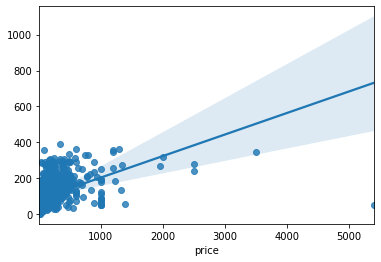

In [36]:
sns.regplot(x=Y_test,y=Y_pred,fit_reg=True)

# LASSO


In [0]:
import warnings
warnings.filterwarnings('ignore') 

In [0]:
from sklearn import linear_model

# split training data into train and validation sets
X_train_lasso, X_val_lasso, y_train_lasso, y_val_lasso = train_test_split (X_train, y_train, 
                                                                           test_size=0.10, random_state=42)
# X_train_lasso.shape
# y_train_lasso.shape

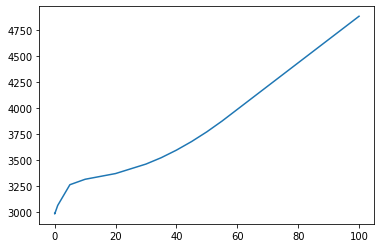

In [81]:
Bilal = [0,1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]

MSE_LASSO = list()
for i in Bilal:
    clf = linear_model.Lasso(alpha= i)
    clf.fit(X_train_lasso, y_train_lasso)
    y_pred_lasso = clf.predict(X_val_lasso)
    mse = mean_squared_error(y_pred_lasso, y_val_lasso)
    MSE_LASSO.append((i, mse))
MSE_LASSO

alpha_tune = [i for i,j in MSE_LASSO]
mse_tune = [j for i,j in MSE_LASSO]

plt.plot(alpha_tune, mse_tune)

#### this result shows that LASSO with alpha = 0 is better (alpha=0 LASSO equals linearRegression). this means no regularization is needed, because we already manuly selected the features

In [83]:
clf = linear_model.Lasso(alpha= 0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_pred, Y_test)
print(" MES of LASSO with alpha =0 ", mse)

 MES of LASSO with alpha =0  23436.796059304037


In [84]:
from sklearn.linear_model import LassoCV
reg = LassoCV(alphas = Bilal, cv=5, random_state=0).fit(X_train, y_train)

# Return the coefficient of determination R^2 of the prediction.
reg.score(X_train, y_train)  

0.36624043596115585

###LASSOCV


In [85]:
 reg.get_params()

{'alphas': [0,
  1e-15,
  1e-10,
  1e-08,
  0.001,
  0.01,
  1,
  5,
  10,
  20,
  30,
  35,
  40,
  45,
  50,
  55,
  100],
 'copy_X': True,
 'cv': 5,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': False,
 'positive': False,
 'precompute': 'auto',
 'random_state': 0,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

In [86]:
y_pred_lassocv = reg.predict(X_test)

mse_lassoCV = mean_squared_error(y_pred_lassocv, Y_test)
print("MSE of LASSOCV: ", mse_lassoCV)

MSE of LASSOCV:  23441.84955920544


# Ridge

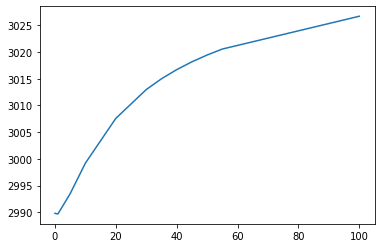

In [87]:
from sklearn.linear_model import Ridge

Bilal = [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]

MSE_ridge = list()
for i in Bilal:
    clf = Ridge(alpha= i)
    clf.fit(X_train_lasso, y_train_lasso)
    y_pred_ridge = clf.predict(X_val_lasso)
    mse = mean_squared_error(y_pred_ridge, y_val_lasso)
    MSE_ridge.append((i, mse))
MSE_ridge

alpha_tune = [i for i,j in MSE_ridge]
mse_tune = [j for i,j in MSE_ridge]

plt.plot(alpha_tune, mse_tune)

### RidgeCV

In [90]:
from sklearn.linear_model import RidgeCV
clf = RidgeCV(alphas=Bilal, cv=5).fit(X_train_lasso, y_train_lasso)
# R^2
clf.score(X_train_lasso, y_train_lasso)

0.36396022206364187

In [91]:
# best alpa
clf.alpha_

0.01

In [89]:
y_pred_ridgecv = clf.predict(X_test)

mse_ridgeCV = mean_squared_error(y_pred_ridgecv, Y_test)
print("MSE of RidgeCV: ", mse_ridgeCV)

MSE of RidgeCV:  23433.745874521075
